## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [47]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [48]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [49]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [50]:
len(fmnist_dataset_test)

10000

In [52]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [53]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [54]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


Your experiments come here:

In [55]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    loss_training, loss_val, acc_val = [], [], []
    for epoch in range(n_epochs):
        ep_loss_training, ep_val_loss, ep_acc_val = [], [], []
        ep_val_loss = []
        ep_acc_val = []
        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)   
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_loss_training.append(loss.item())
        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:           
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_fn(out, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_acc_val.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        print("epoch ", end='')
        print(epoch)

        loss_training.append(np.mean(ep_loss_training))
        loss_val.append(np.mean(ep_val_loss))
        acc_val.append(np.mean(ep_acc_val))

        print("training loss:     ", end='') 
        print(loss_training[-1])
        print("validation accuracy:     ", end='')
        print(acc_val[-1])
    return loss_training, loss_val, acc_val

n_epochs = 15
import time
loss_training, loss_val, acc_val = train_model(model, train_loader, test_loader, loss_function, opt, n_epochs)

epoch 0
training loss:     0.6001486126929204
validation accuracy:     0.84013671875
epoch 1
training loss:     0.4097531468692873
validation accuracy:     0.852734375
epoch 2
training loss:     0.3610448728619354
validation accuracy:     0.85849609375
epoch 3
training loss:     0.33542456581140123
validation accuracy:     0.8662109375
epoch 4
training loss:     0.31501499787449583
validation accuracy:     0.86982421875
epoch 5
training loss:     0.29935844236218345
validation accuracy:     0.87919921875
epoch 6
training loss:     0.283377301813697
validation accuracy:     0.8794921875
epoch 7
training loss:     0.27512030392440395
validation accuracy:     0.88037109375
epoch 8
training loss:     0.2637983915298732
validation accuracy:     0.88134765625
epoch 9
training loss:     0.25081489997695505
validation accuracy:     0.88095703125
epoch 10
training loss:     0.24577661298676087
validation accuracy:     0.881640625
epoch 11
training loss:     0.2390161592092341
validation accurac

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [56]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.LeakyReLU(),
            nn.Linear(500,300),
            nn.LeakyReLU(),
            nn.Linear(300, 100),
            nn.LeakyReLU(),
            nn.Linear(100,10),
            nn.LeakyReLU(),
            nn.Linear(10,num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [57]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
         LeakyReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
         LeakyReLU-9                   [-1, 10]               0
           Linear-10                   [-1, 10]             110
Total params: 574,020
Trainable params: 574,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.19
Estimated T

In [58]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 25
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

epoch 0
training loss:     0.6712527637923958
validation accuracy:     0.8431640625
epoch 1
training loss:     0.393494827724469
validation accuracy:     0.84716796875
epoch 2
training loss:     0.3447919708769967
validation accuracy:     0.8681640625
epoch 3
training loss:     0.3170072427118765
validation accuracy:     0.876953125
epoch 4
training loss:     0.30006606463811547
validation accuracy:     0.866796875
epoch 5
training loss:     0.2810200858853265
validation accuracy:     0.87392578125
epoch 6
training loss:     0.2683188936381198
validation accuracy:     0.88046875
epoch 7
training loss:     0.2555237873467301
validation accuracy:     0.8787109375
epoch 8
training loss:     0.24324150798099636
validation accuracy:     0.881640625
epoch 9
training loss:     0.23513505253583383
validation accuracy:     0.887109375
epoch 10
training loss:     0.22319048789264298
validation accuracy:     0.88974609375
epoch 11
training loss:     0.21609236504922288
validation accuracy:     0.

0.8986328125


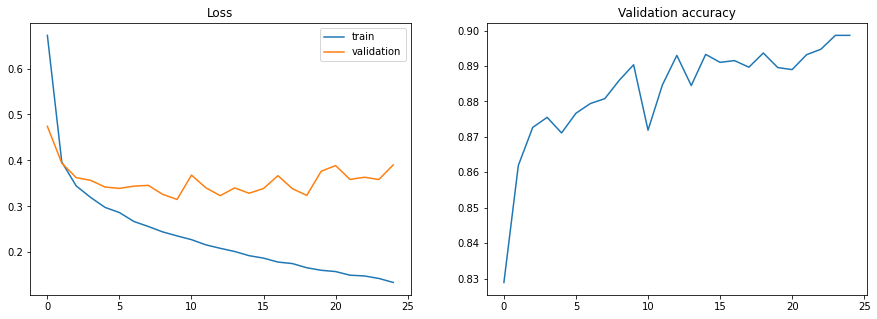

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].legend()
axes[1].set_title('Validation accuracy')
axes[1].plot(val_accuracy)
print(np.max(val_accuracy))

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [35]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(600,500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400,300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(300,200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(), 
            nn.Linear(200,100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100,10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [36]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
       BatchNorm1d-3                  [-1, 600]           1,200
         LeakyReLU-4                  [-1, 600]               0
           Dropout-5                  [-1, 600]               0
            Linear-6                  [-1, 500]         300,500
       BatchNorm1d-7                  [-1, 500]           1,000
         LeakyReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 400]         200,400
      BatchNorm1d-11                  [-1, 400]             800
        LeakyReLU-12                  [-1, 400]               0
          Dropout-13                  [-1, 400]               0
           Linear-14                  [

In [37]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 20
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 20 took 9.064s
	  training loss: 0.946158
	validation loss: 0.519649
	validation accuracy: 0.811
Epoch 2 of 20 took 9.802s
	  training loss: 0.587013
	validation loss: 0.474981
	validation accuracy: 0.830
Epoch 3 of 20 took 9.705s
	  training loss: 0.525097
	validation loss: 0.420111
	validation accuracy: 0.855
Epoch 4 of 20 took 9.084s
	  training loss: 0.477704
	validation loss: 0.387078
	validation accuracy: 0.866
Epoch 5 of 20 took 9.119s
	  training loss: 0.453583
	validation loss: 0.378172
	validation accuracy: 0.870
Epoch 6 of 20 took 9.075s
	  training loss: 0.438957
	validation loss: 0.367828
	validation accuracy: 0.867
Epoch 7 of 20 took 9.069s
	  training loss: 0.424263
	validation loss: 0.353945
	validation accuracy: 0.874
Epoch 8 of 20 took 8.990s
	  training loss: 0.409486
	validation loss: 0.362882
	validation accuracy: 0.873
Epoch 9 of 20 took 9.077s
	  training loss: 0.400452
	validation loss: 0.348353
	validation accuracy: 0.875
Epoch 10 of 20 took 9.065s
	

0.889453125


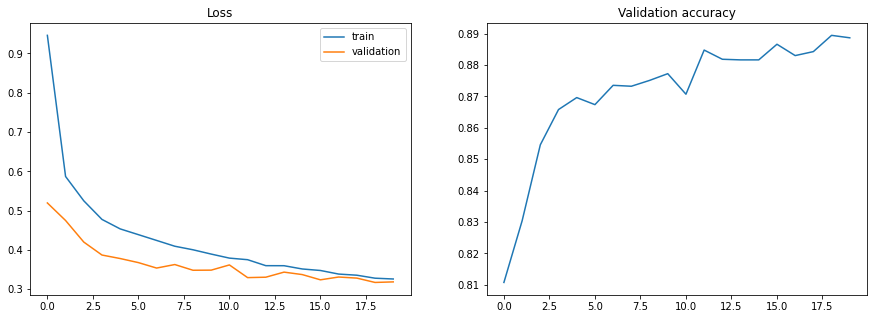

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].legend()
axes[1].set_title('Validation accuracy')
axes[1].plot(val_accuracy)
print(np.max(val_accuracy))

### Conclusions:
_Write down small report with your conclusions and your ideas._

The training accuracy increases with increase in number of epochs.
The effectiveness of tools like batchnorm and dropout in reducing overfitting also serves as evidence of how well these techniques work in creating better models.
